### 1. Import

In [1]:
from ultralytics import YOLO
import numpy as np
from pathlib import Path
import  cv2
from lib.helpfunctions import get_image
import os
import rembg
import random
import matplotlib.pyplot as plt

yolo = YOLO('models/YoloModel.onnx',task='segment')

### 2. Take random Picture

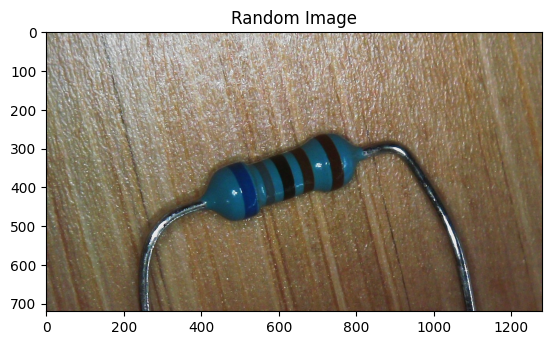

In [2]:
dataset = './Datasets/Original_Dataset'
image_path = get_image(dataset)
image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.title("Random Image")
plt.imshow(image)

### 3. Remove Background

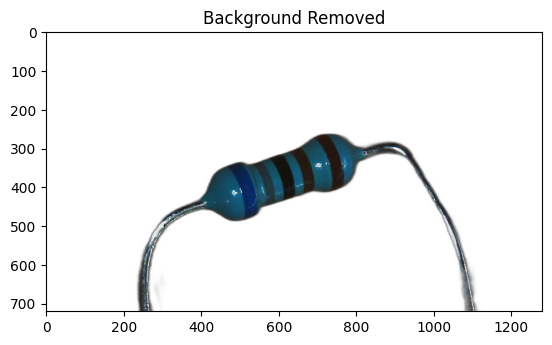

In [3]:
image_nobg = rembg.remove(image,bgcolor=(255,255,255,255))
if image_nobg.shape[-1] == 4:  # Remove alpha channel
    image_nobg = image_nobg[:, :, :3]
plt.title("Background Removed")
plt.imshow(image_nobg)


### 4. Interference with YOLO-Model

Loading models\YoloModel.onnx for ONNX Runtime inference...
Preferring ONNX Runtime AzureExecutionProvider

0: 640x640 1 Resistor, 211.2ms
Speed: 8.5ms preprocess, 211.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


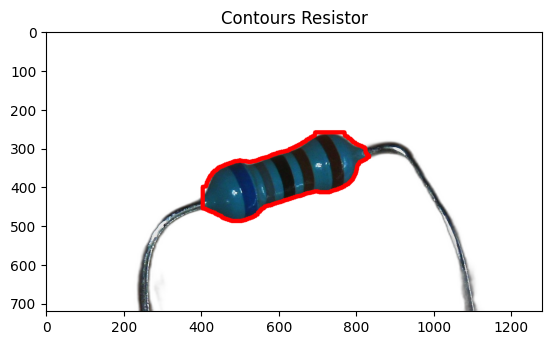

In [4]:
result_model = yolo.predict(image_nobg)  
if result_model[0].masks is not None:
    mask = np.zeros_like(image_nobg, dtype=np.uint8)  # Create a blank mask of the same size as the image
    
    result = result_model[0].masks.xy[0]
    # Convert the polygon list to a numpy array
    polygon_array = np.array(result, np.int32)
    polygon_array = polygon_array.reshape((-1, 1, 2))
    
    # Draw the polygon on the mask (white on black)
    cv2.fillPoly(mask, [polygon_array], color=(255, 255, 255))  # White mask for the region

    # Apply the mask to get the polygon cutout
    masked_region = cv2.bitwise_and(image_nobg, mask)

    # Convert the masked region to grayscale to simplify the rotation and bounding box extraction
    gray_masked = cv2.cvtColor(masked_region, cv2.COLOR_BGR2GRAY)

    # Find the contours of the masked region
    contours, _ = cv2.findContours(gray_masked, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Select the largest contour for precision
    cnt = max(contours, key=cv2.contourArea)
    
    #Draw Contours and Display
    image_copy = image_nobg.copy()
    cv2.drawContours(image_copy, contours, -1, (255, 0, 0), 10)
    plt.title("Contours Resistor")
    plt.imshow(image_copy)
else:
    print("Couldn't detect Resistor")

### 5. Get Bounding Box 

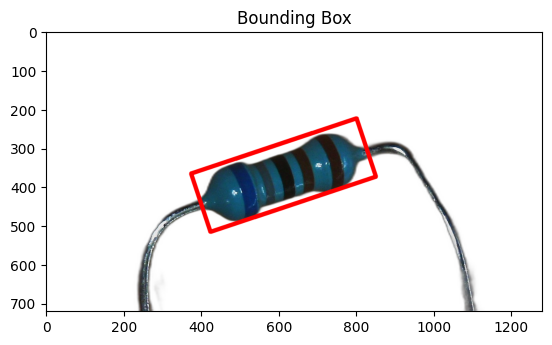

In [5]:
# Get the minimum area bounding rectangle for the contour
rect = cv2.minAreaRect(cnt)  # Get the minimum area rectangle
box = cv2.boxPoints(rect)  # Get the 4 points of the bounding box
box = np.intp(box)  # Convert to integer

# Debugging: Show the bounding box on the masked region
image_copy = image_nobg.copy()
cv2.drawContours(image_copy, [box], -1, (255, 0, 0),10)
plt.imshow(image_copy)
plt.title("Bounding Box")
plt.show()

### 6. Rotate, Crop and Resize Resistor

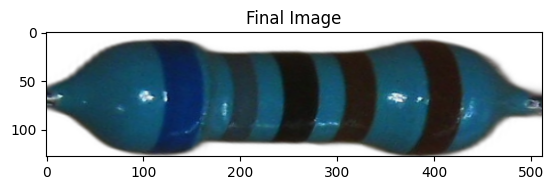

In [7]:
angle = rect[-1]
if angle < -45:
    angle += 90

# Compute the center of rotation
(h, w) = image_nobg.shape[:2]
center = tuple(map(int, rect[0]))  # Center of bounding box

# Compute rotation matrix
rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

# Compute the new image dimensions
cos = abs(rotation_matrix[0, 0])
sin = abs(rotation_matrix[0, 1])
new_w = int(w * cos + h * sin)
new_h = int(h * cos + w * sin)

# Adjust rotation matrix for translation
rotation_matrix[0, 2] += (new_w / 2) - center[0]
rotation_matrix[1, 2] += (new_h / 2) - center[1]

# Rotate the image
rotated_image = cv2.warpAffine(image_nobg, rotation_matrix, (new_w, new_h))

# Transform bounding box points
rotated_box = cv2.transform(np.array([box], dtype=np.float32), rotation_matrix)

# Compute the bounding rectangle of the rotated box
x, y, w, h = cv2.boundingRect(rotated_box)

# Extract the cropped region
cropped_region = rotated_image[y:y+h, x:x+w]

# Ensure consistent width > height orientation
if cropped_region.shape[0] > cropped_region.shape[1]:
    cropped_region = cv2.rotate(cropped_region, cv2.ROTATE_90_CLOCKWISE)

cropped_region = cv2.resize(cropped_region, (512, 128), interpolation = cv2.INTER_LINEAR)


plt.imshow(cropped_region)
plt.title("Final Image")
plt.show()